# Bonus: Proteus and Fowleri *Detection*

This notebook will guide students to distinguish between two types of amoebae: Amoeba proteus and Naegleria fowleri.

## Table of content


* Set up environment
* Load images dataset
* Train custom amoeba model
* Evaluate amoeba model
* Inference

# Set up environment

In [ ]:
!pip install keras==2.1.6
!pip install tensorflow==1.15.0
!pip install h5py==2.10.0

In [ ]:
%%shell
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
python setup.py install

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

# Load images dataset

In [ ]:
# download dataset from github

# %%shell
# # clone pro and fow dataset 
# git clone https://github.com/BaosenZ/amoeba-detection.git


In [ ]:
# upload zip of the dataset 
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

!unzip trainingDataset.zip
!unzip testDataset.zip

# Train amoeba dataset

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

class AmoebaDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "Proteus Amoeba")
        self.add_class("dataset",2,"N.Fowleri Amoeba")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in listdir(images_dir):
            image_id = filename[:-4]
            if is_train and int(image_id) >= 54:
                continue
            if not is_train and int(image_id) < 54:
                continue
            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'
            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    # # load the masks for an image
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)

        tree = ElementTree.parse(path)
        root = tree.getroot()

        masks = zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = list()

        i = 0
        for obj in root.findall('.//object'):
        #for i in range(len(boxes)):
            if obj.find('name').text == 'Proteus Amoeba':
                box = boxes[i]
                row_s, row_e = box[1], box[3]
                col_s, col_e = box[0], box[2]
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('Proteus Amoeba'))
            if obj.find('name').text == 'N.Fowleri Amoeba':
                box = boxes[i]
                row_s, row_e = box[1], box[3]
                col_s, col_e = box[0], box[2]
                masks[row_s:row_e, col_s:col_e, i] = 1
                class_ids.append(self.class_names.index('N.Fowleri Amoeba'))
            i = i + 1
        return masks, asarray(class_ids, dtype='int32')

    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

class AmoebaConfig(Config):
    NAME = "amoeba_cfg"
    NUM_CLASSES = 1 + 2
    STEPS_PER_EPOCH = 131
    DETECTION_NMS_THRESHOLD = 0.5

# prepare train set
train_set = AmoebaDataset()
train_set.load_dataset('trainingDataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare val set
val_set = AmoebaDataset()
val_set.load_dataset('trainingDataset', is_train=False)
val_set.prepare()
print('Val: %d' % len(val_set.image_ids))
# prepare config
config = AmoebaConfig()
config.display()



In [ ]:
# run tensorboard
import keras
import os
root_logdir = os.path.join(os.curdir, "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print(run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

In [ ]:
# train the model
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('Mask_RCNN/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])
model.train(train_set, val_set, learning_rate=0.002, epochs=20, layers='heads', custom_callbacks=[tensorboard_cb])

# Evaluate amoeba dataset
 


In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

class PredictionConfig(Config):
	NAME = "amoeba_cfg"
	NUM_CLASSES = 1 + 2
	GPU_COUNT = 1
	IMAGES_PER_GPU = 1

# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
	APs = list()
	for image_id in dataset.image_ids:
		image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
		scaled_image = mold_image(image, cfg)
		sample = expand_dims(scaled_image, 0)
		yhat = model.detect(sample, verbose=0)
		r = yhat[0]
		AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
		APs.append(AP)
	# calculate the mean AP across all images
	mAP = mean(APs)
	return APs, mAP

# load the test dataset
test_set = AmoebaDataset()
test_set.load_dataset('testDataset', is_train = False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))
# create config
cfg = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
# load model weights
model.load_weights('amoeba_cfg20211005T1749/mask_rcnn_amoeba_cfg_0020.h5', by_name=True) #the directory can be changed
# evaluate model on test dataset
test_APs, test_mAP = evaluate_model(test_set, model, cfg)
print(test_APs, test_mAP)

# Inference

## Test dataset inference



In [ ]:
!rm -rf c1 predImagesC1

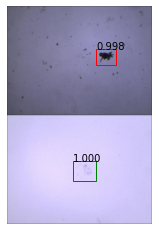

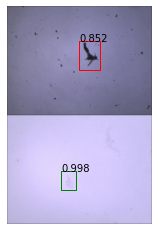

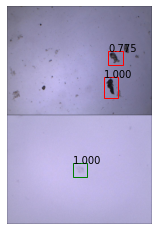

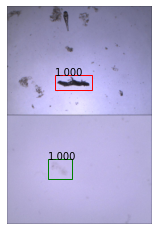

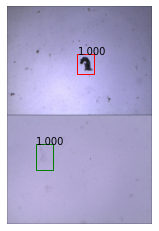

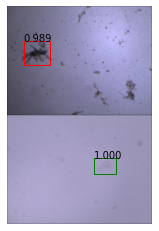

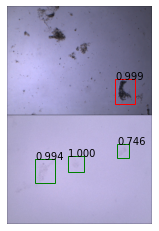

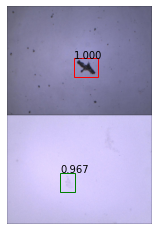

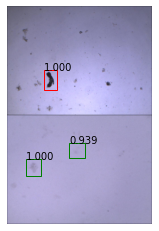

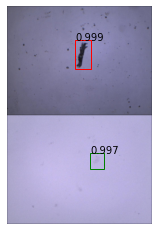

In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def save_predicted(image, model, cfg, filename):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  #print(yhat)
  pyplot.imshow(image)
  ax = pyplot.gca()
  pyplot.axis("off")
  for box,ids,confidence in zip(yhat['rois'],yhat['class_ids'],yhat['scores']):
    if ids == 1:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      confidence = format(confidence, '.3f')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)
    if ids == 2:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='green')
      confidence = format(confidence, '.3f')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)

  filename ="testDataset-pred/" + filename
  pyplot.savefig(filename,bbox_inches='tight',pad_inches=0.0)
  pyplot.show()

from PIL import Image
if not os.path.exists("testDataset-pred"):
  os.mkdir("testDataset-pred")

images_dir = "testDataset/images"
for img in listdir(images_dir):
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  #plot_predicted(image, model, cfg)
  save_predicted(image, model, cfg, img)

In [ ]:
!zip -r testDataset-pred.zip testDataset-pred
from google.colab import files
files.download("testDataset-pred.zip")

updating: testDataset-pred/ (stored 0%)
  adding: testDataset-pred/64.jpg (deflated 2%)
  adding: testDataset-pred/68.jpg (deflated 2%)
  adding: testDataset-pred/67.jpg (deflated 2%)
  adding: testDataset-pred/70.jpg (deflated 2%)
  adding: testDataset-pred/65.jpg (deflated 2%)
  adding: testDataset-pred/72.jpg (deflated 2%)
  adding: testDataset-pred/71.jpg (deflated 2%)
  adding: testDataset-pred/66.jpg (deflated 2%)
  adding: testDataset-pred/63.jpg (deflated 2%)
  adding: testDataset-pred/69.jpg (deflated 2%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training dataset inference

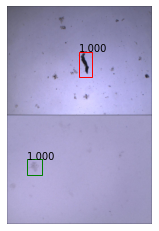

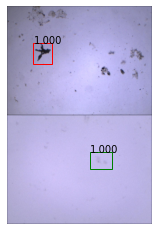

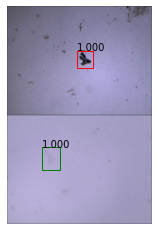

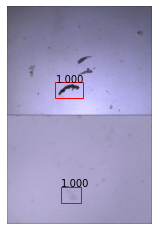

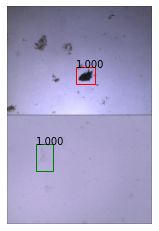

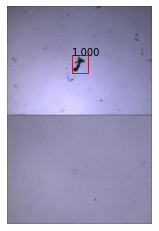

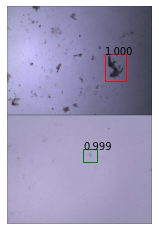

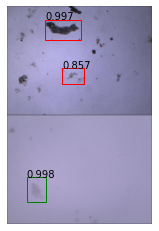

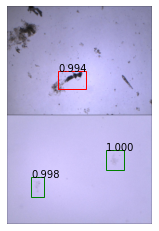

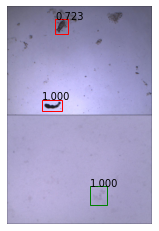

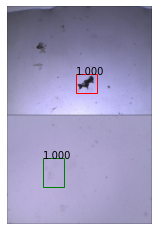

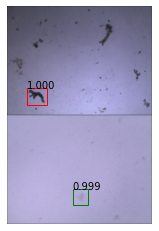

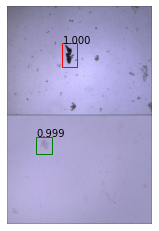

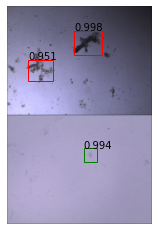

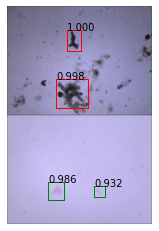

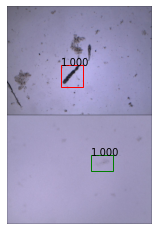

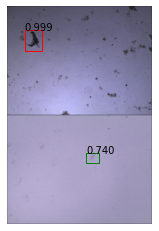

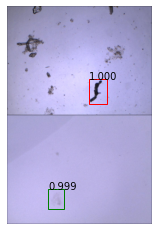

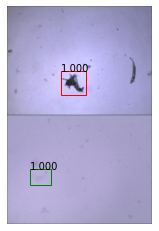

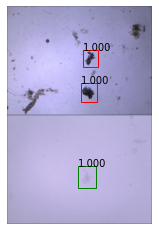

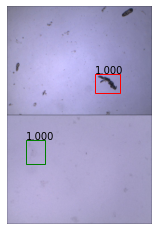

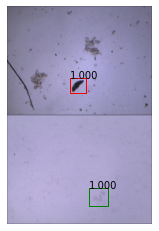

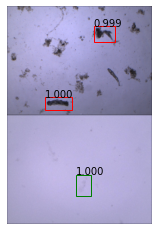

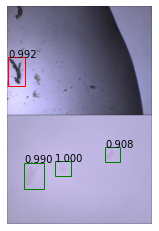

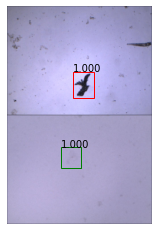

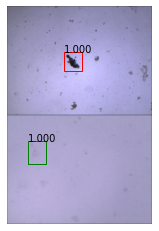

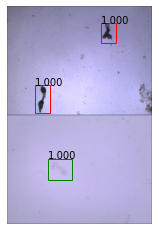

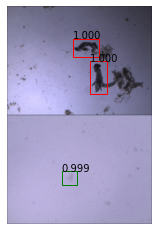

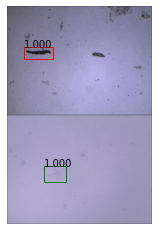

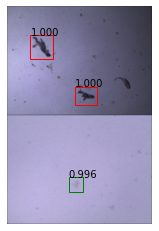

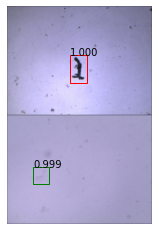

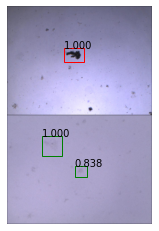

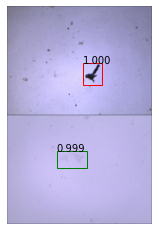

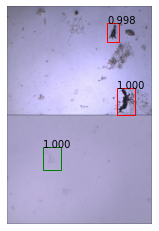

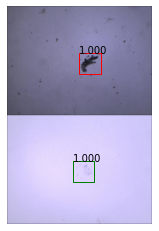

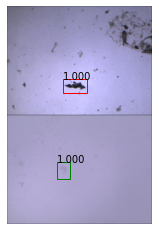

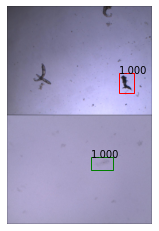

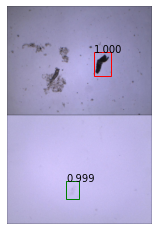

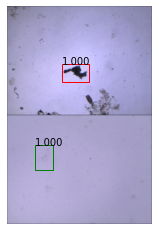

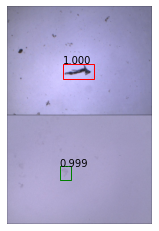

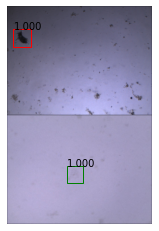

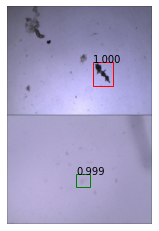

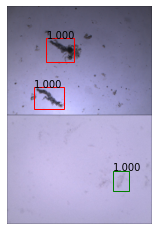

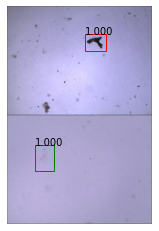

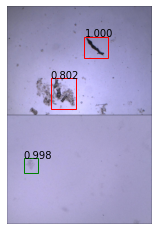

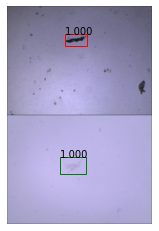

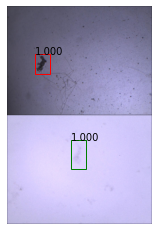

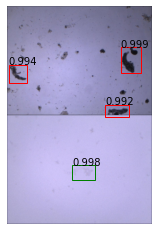

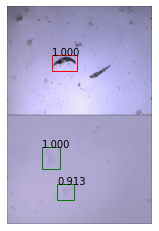

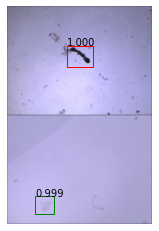

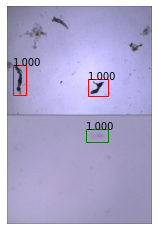

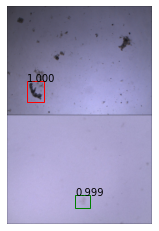

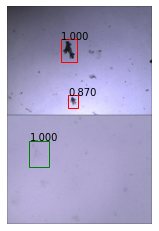

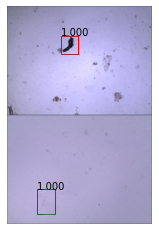

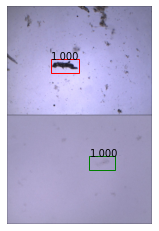

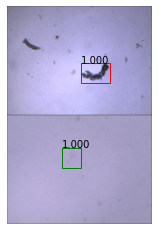

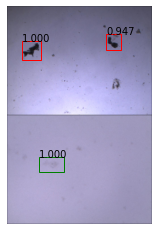

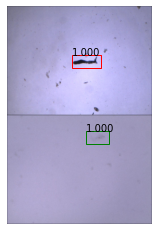

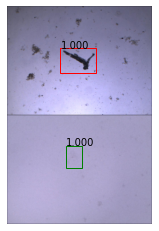

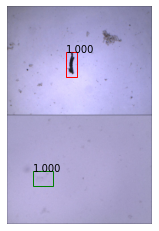

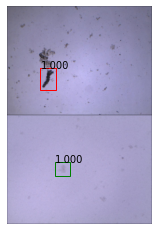

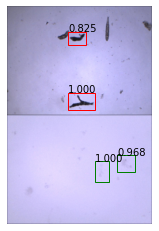

In [ ]:
from matplotlib import pyplot
from matplotlib.patches import Rectangle

def save_predicted(image, model, cfg, filename):
  image = np.asanyarray(image)
  scaled_image = mold_image(image, cfg)
  sample = expand_dims(image, 0)
  yhat = model.detect(sample, verbose=0)[0]
  #print(yhat)
  pyplot.imshow(image)
  ax = pyplot.gca()
  pyplot.axis("off")
  for box,ids,confidence in zip(yhat['rois'],yhat['class_ids'],yhat['scores']):
    if ids == 1:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')
      confidence = format(confidence, '.3f')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)
    if ids == 2:
      y1, x1, y2, x2 = box
      width, height = x2 - x1, y2 - y1
      rect = Rectangle((x1, y1), width, height, fill=False, color='green')
      confidence = format(confidence, '.3f')
      pyplot.text(x1,y1,confidence)
      ax.add_patch(rect)

  filename ="trainingDataset-pred/" + filename
  pyplot.savefig(filename,bbox_inches='tight',pad_inches=0.0)
  pyplot.show()

from PIL import Image
if not os.path.exists("trainingDataset-pred"):
  os.mkdir("trainingDataset-pred")

images_dir = "trainingDataset/images"

for img in listdir(images_dir):
  img_path = images_dir + "/" + img
  image = Image.open(img_path)
  image = np.asanyarray(image)
  #plot_predicted(image, model, cfg)
  save_predicted(image, model, cfg, img)



In [ ]:
!zip -r trainingDataset-pred.zip trainingDataset-pred
from google.colab import files
files.download("trainingDataset-pred.zip")

  adding: trainingDataset-pred/ (stored 0%)
  adding: trainingDataset-pred/19.jpg (deflated 2%)
  adding: trainingDataset-pred/48.jpg (deflated 2%)
  adding: trainingDataset-pred/5.jpg (deflated 2%)
  adding: trainingDataset-pred/2.jpg (deflated 2%)
  adding: trainingDataset-pred/25.jpg (deflated 2%)
  adding: trainingDataset-pred/60.jpg (deflated 2%)
  adding: trainingDataset-pred/47.jpg (deflated 2%)
  adding: trainingDataset-pred/58.jpg (deflated 2%)
  adding: trainingDataset-pred/61.jpg (deflated 2%)
  adding: trainingDataset-pred/16.jpg (deflated 2%)
  adding: trainingDataset-pred/8.jpg (deflated 2%)
  adding: trainingDataset-pred/45.jpg (deflated 2%)
  adding: trainingDataset-pred/14.jpg (deflated 2%)
  adding: trainingDataset-pred/54.jpg (deflated 2%)
  adding: trainingDataset-pred/59.jpg (deflated 2%)
  adding: trainingDataset-pred/33.jpg (deflated 2%)
  adding: trainingDataset-pred/56.jpg (deflated 2%)
  adding: trainingDataset-pred/35.jpg (deflated 2%)
  adding: trainingDatas

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("amoeba_cfg20211005T1749/mask_rcnn_amoeba_cfg_0020.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("/content/my_logs/run_2021_10_05-17_48_59/events.out.tfevents.1633456162.1ef3635c691b")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>